# Amiyah Stukes Project 2

Import (including the correct names of the variables) the data from the QSAR Fish Toxicity research: https://archive.ics.uci.edu/ml/datasets/QSAR+fish+toxicity On this webpage you will find a description of the explanatory variables and the dependent variable. Implement 10-fold cross validations and the correct data preprocessing, make polynomial models of degree 1, 2 and 3 and determine which degree achieves the best external validation.  For this, you will use the regularized regression models such as Ridge, Lasso and ElasticNet and you will also determine the best value of the hyperparameter alpha in each case. In the case of ElasticNet, the second hyperparameter, L1 ratio, can be assumed to be 0.5. 


After you obtained the best choice of polynomial degree and hyperparameter alpha compute the residuals of the best model on the whole data and determine whether they follow a normal distribution.

In [1]:
#importing libraries
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 150
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from datetime import datetime as dt 
from IPython.display import clear_output
from sklearn.svm import SVR
from sklearn.model_selection import KFold 
from sklearn.metrics import mean_squared_error as MSE
import seaborn as sns
from scipy.stats import norm
from scipy import stats
import statsmodels.api as sm

# Importing the data

In [2]:
#importing the data and getting rid of semicolons and changing column names
data = pd.read_csv("drive/MyDrive/Data Sets DATA 310/qsar_fish_toxicity (2).csv", 
                   sep=";",
                   names = ["CIC0","SM1_Dz(Z)","GATS1i","NdsCH","NdssC","MLOGP","quantitative response, LC50[-LOG(mol/L)]"])

In [3]:
#displaying new data frame
data

,CIC0,SM1_Dz(Z),GATS1i,NdsCH,NdssC,MLOGP,"quantitative response, LC50[-LOG(mol/L)]"
0,3.260,0.829,1.676,0,1,1.453,3.770
1,2.189,0.580,0.863,0,0,1.348,3.115
2,2.125,0.638,0.831,0,0,1.348,3.531
3,3.027,0.331,1.472,1,0,1.807,3.510
4,2.094,0.827,0.860,0,0,1.886,5.390
...,...,...,...,...,...,...,...
903,2.801,0.728,2.226,0,2,0.736,3.109
904,3.652,0.872,0.867,2,3,3.983,4.040
905,3.763,0.916,0.878,0,6,2.918,4.818
906,2.831,1.393,1.077,0,1,0.906,5.317


In [4]:
x = data.iloc[:,:-1].values #extracting the input values
y = data.iloc[:,-1].values #extracting the dependent variable

In [5]:
x

array([[3.26 , 0.829, 1.676, 0.   , 1.   , 1.453],
       [2.189, 0.58 , 0.863, 0.   , 0.   , 1.348],
       [2.125, 0.638, 0.831, 0.   , 0.   , 1.348],
       ...,
       [3.763, 0.916, 0.878, 0.   , 6.   , 2.918],
       [2.831, 1.393, 1.077, 0.   , 1.   , 0.906],
       [4.057, 1.032, 1.183, 1.   , 3.   , 4.754]])

In [6]:
x.shape

(908, 6)

In [7]:
y

array([3.77 , 3.115, 3.531, 3.51 , 5.39 , 1.819, 3.947, 3.513, 4.402,
       3.021, 3.21 , 2.371, 3.919, 3.03 , 2.736, 2.157, 2.413, 0.898,
       0.45 , 3.733, 2.976, 6.535, 5.643, 4.629, 4.838, 4.081, 3.436,
       3.45 , 1.102, 4.257, 5.386, 3.393, 1.308, 3.554, 2.269, 4.165,
       5.896, 4.829, 4.59 , 2.092, 3.665, 3.56 , 4.805, 3.174, 7.899,
       2.67 , 4.016, 3.857, 5.522, 4.851, 3.84 , 4.586, 5.284, 3.559,
       4.091, 4.33 , 3.755, 4.552, 3.62 , 4.459, 2.827, 6.38 , 4.786,
       3.861, 3.262, 6.297, 3.546, 2.92 , 3.203, 2.283, 1.559, 3.47 ,
       4.748, 2.576, 5.259, 4.564, 4.37 , 0.053, 2.381, 2.891, 1.088,
       3.721, 3.701, 6.083, 4.628, 3.7  , 1.842, 3.396, 2.99 , 3.573,
       2.271, 2.085, 3.822, 3.29 , 3.84 , 3.979, 3.47 , 3.314, 4.031,
       4.74 , 4.194, 3.447, 2.364, 3.645, 2.07 , 2.27 , 3.513, 2.811,
       2.832, 1.639, 2.016, 1.651, 4.097, 3.123, 3.231, 5.052, 3.572,
       2.436, 2.567, 1.795, 5.072, 2.156, 1.037, 1.932, 2.505, 1.524,
       3.048, 5.115,

In [8]:
y.shape

(908,)

## Making our k-fold Function

In [9]:
# function for testing our models
def model_testing(x,y,model,k,d,rs): #k=number of folds, d=degree of polynomial, model=Ridge,Lasso,ElasticNet, rs=randomstate
  kfold = KFold(n_splits=k, shuffle=True, random_state=rs)
  # keeping track of training and test data
  R2train = []
  R2test = []

  #we can also keep track of MSE(but this is equivalent to R2
  #R2 = 1 - n*MSE/sum(y-mean(y))^2
  #MSEtrain = []
  #MSEtest = []

  #writing loop
  #we also want to create a pipeline for pre-processing, such as scaling and polynomial features 
  scale = StandardScaler()
  poly = PolynomialFeatures(degree=d)

  #creating pipeline
  pipe = Pipeline([['Scaling',scale],['Polynomial Features',poly]])

  for idxtrain, idxtest in kfold.split(x):
    xtrain = x[idxtrain]
    xtest = x[idxtest]
    ytrain = y[idxtrain]
    ytest = y[idxtest]

    #next we apply the pipeline to the input features

    xpoly_train = pipe.fit_transform(xtrain)
    xpoly_test = pipe.transform(xtest)

    model.fit(xpoly_train,ytrain) #fitting the model on our input features
    R2train.append(model.score(xpoly_train,ytrain)) #adding our training scores to the training list
    R2test.append(model.score(xpoly_test,ytest)) #adding our testing scores to the testing list
    #MSEtrain.append(MSE(ytrain,model.predict(xpoly_train)))
    #MSEtest.append(MSE(ytest,model.predict(xpoly_test)))

  return np.mean(R2train), np.mean(R2test) #return the mean of the lists #np.mean(MSEtrain),np.mean(MSEtest)

### Degree 1: Ridge

In [10]:
#ridge regression degree 1
a_range = np.linspace(1e-6,3.5,10) #where to look for alpha
k=10 #number of folds 
mean_R2train = [] #keeping track of mean r2 train
mean_R2test = [] #keeping track of mean r2 test
#mean_MSEtrain = []
#mean_MSEtest = []

tStart = dt.now()#timer
for a in a_range:
  clear_output()
  print('Running a=', a)
  model = Ridge(alpha=a,fit_intercept=False) #selecting our model
  print(dt.now()-tStart)
  R2train, R2test = model_testing(x,y,model,k,1,123) #testing our model with data, number of folds, degree of polynomial and randomstate
  mean_R2train.append(np.mean(R2train)) #adding our results to training list
  mean_R2test.append(np.mean(R2test)) #adding our results to testing list
  #mean_MSEtrain.append(np.mean(MSEtrain))
  #mean_MSEtest.append(np.mean(MSEtest))

Running a= 3.5
0:00:00.330661


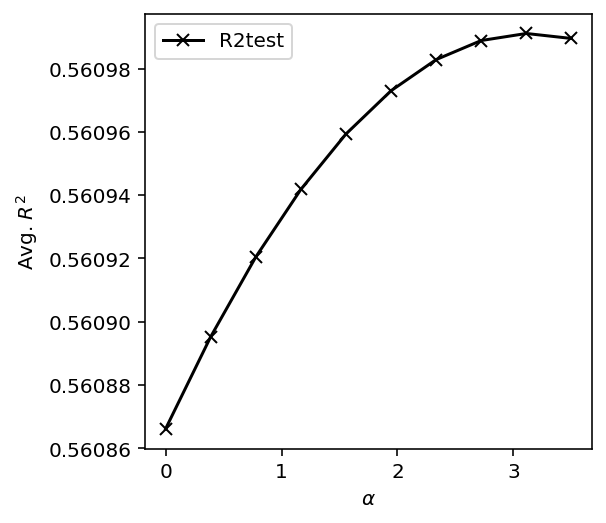

In [11]:
plt.figure(figsize=(4,4))
plt.plot(a_range,mean_R2test,'-xk', label='R2test')
#plt.plot(a_range,mean_MSEtest,'-xr', label='MSE')
plt.xlabel('$\\alpha$')
plt.ylabel('Avg. $R^2$')
plt.legend()
plt.show()

In [12]:
idx_max = np.argmax(mean_R2test)
[mean_R2test[idx_max], a_range[idx_max]]

[0.5609910868939039, 3.111111222222222]

### Degree 2: Ridge

In [13]:
#ridge degree 2
a_range = np.linspace(1e-6,0.45,10)
k=10
mean_R2train = []
mean_R2test = []
#mean_MSEtrain = []
#mean_MSEtest = []

tStart = dt.now()
for a in a_range:
  clear_output()
  print('Running a=', a)
  model = Ridge(alpha=a,fit_intercept=False)
  print(dt.now()-tStart)
  R2train, R2test = model_testing(x,y,model,k,2,123)
  mean_R2train.append(np.mean(R2train))
  mean_R2test.append(np.mean(R2test))
  #mean_MSEtrain.append(np.mean(MSEtrain))
  #mean_MSEtest.append(np.mean(MSEtest))

Running a= 0.45
0:00:00.487692


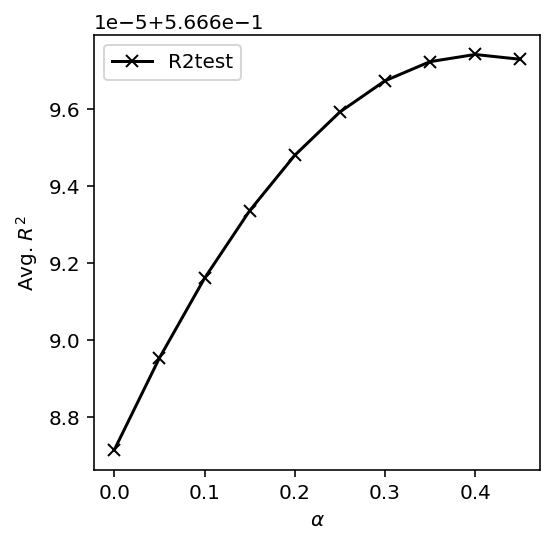

In [14]:
plt.figure(figsize=(4,4))
plt.plot(a_range,mean_R2test,'-xk', label='R2test')
#plt.plot(a_range,mean_MSEtest,'-xr', label='MSE')
plt.xlabel('$\\alpha$')
plt.ylabel('Avg. $R^2$')
plt.legend()
plt.show()

In [15]:
idx_max = np.argmax(mean_R2test)
[mean_R2test[idx_max], a_range[idx_max]]

[0.5666974138428501, 0.4000001111111111]

### Degree 3: Ridge

In [25]:
a_range = np.linspace(1e-6,9.5,10)
k=10
mean_R2train = []
mean_R2test = []
#mean_MSEtrain = []
#mean_MSEtest = []

tStart = dt.now()
for a in a_range:
  clear_output()
  print('Running a=', a)
  model = Ridge(alpha=a,fit_intercept=False)
  print(dt.now()-tStart)
  R2train, R2test = model_testing(x,y,model,k,3,123)
  mean_R2train.append(np.mean(R2train))
  mean_R2test.append(np.mean(R2test))
  #mean_MSEtrain.append(np.mean(MSEtrain))
  #mean_MSEtest.append(np.mean(MSEtest))

Running a= 9.5
0:00:01.263805


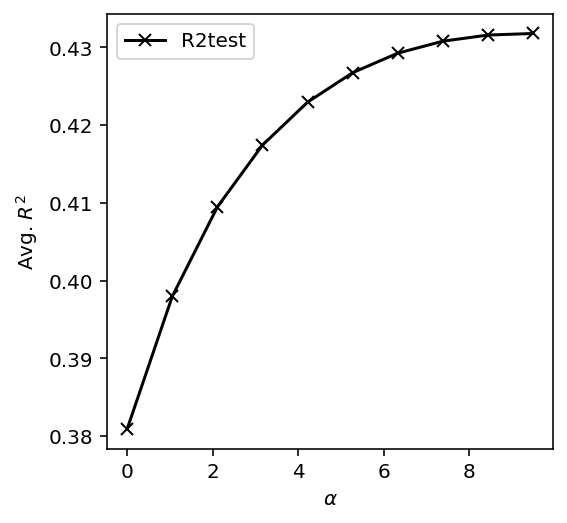

In [26]:
plt.figure(figsize=(4,4))
plt.plot(a_range,mean_R2test,'-xk', label='R2test')
#plt.plot(a_range,mean_MSEtest,'-xr', label='MSE')
plt.xlabel('$\\alpha$')
plt.ylabel('Avg. $R^2$')
plt.legend()
plt.show()

In [27]:
idx_max = np.argmax(mean_R2test)
[mean_R2test[idx_max], a_range[idx_max]]

[0.43178862509794486, 9.5]

# Results: Ridge 


*   Best degree: 2
*  r2 value: .57
*   alpha value: .40





### Degree 1: Lasso

In [40]:
a_range = np.linspace(1e-6,0.006,10)
k=10
mean_R2train = []
mean_R2test = []
#mean_MSEtrain = []
#mean_MSEtest = []

tStart = dt.now()
for a in a_range:
  clear_output()
  print('Running a=', a)
  model = Lasso(alpha=a,fit_intercept=False)
  print(dt.now()-tStart)
  R2train, R2test = model_testing(x,y,model,k,1,123)
  mean_R2train.append(np.mean(R2train))
  mean_R2test.append(np.mean(R2test))
  #mean_MSEtrain.append(np.mean(MSEtrain))
  #mean_MSEtest.append(np.mean(MSEtest))

Running a= 0.006
0:00:00.560822


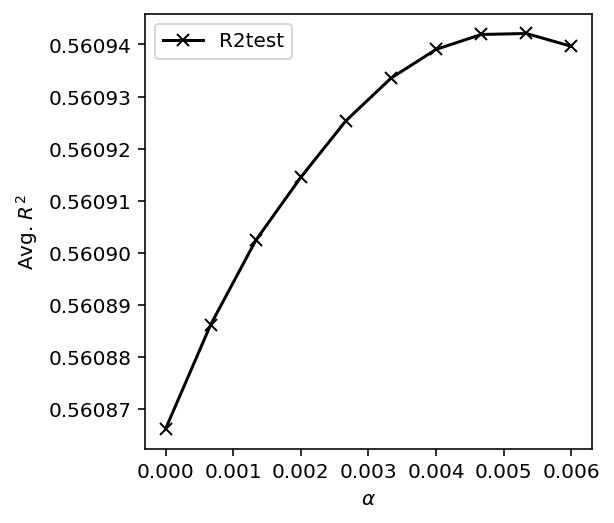

In [41]:
plt.figure(figsize=(4,4))
plt.plot(a_range,mean_R2test,'-xk', label='R2test')
#plt.plot(a_range,mean_MSEtest,'-xr', label='MSE')
plt.xlabel('$\\alpha$')
plt.ylabel('Avg. $R^2$')
plt.legend()
plt.show()

In [42]:
idx_max = np.argmax(mean_R2test)
[mean_R2test[idx_max], a_range[idx_max]]

[0.5609420991689462, 0.0053334444444444445]

### Degree 2: Lasso

In [34]:
a_range = np.linspace(1e-6,0.027,10)
k=10
mean_R2train = []
mean_R2test = []
#mean_MSEtrain = []
#mean_MSEtest = []

tStart = dt.now()
for a in a_range:
  clear_output()
  print('Running a=', a)
  model = Lasso(alpha=a,fit_intercept=False)
  print(dt.now()-tStart)
  R2train, R2test = model_testing(x,y,model,k,2,123)
  mean_R2train.append(np.mean(R2train))
  mean_R2test.append(np.mean(R2test))
  #mean_MSEtrain.append(np.mean(MSEtrain))
  #mean_MSEtest.append(np.mean(MSEtest))

Running a= 0.027
0:00:01.166981


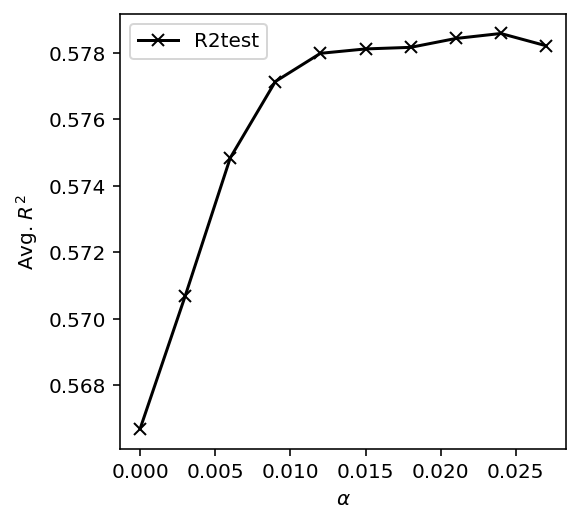

In [35]:
plt.figure(figsize=(4,4))
plt.plot(a_range,mean_R2test,'-xk', label='R2test')
#plt.plot(a_range,mean_MSEtest,'-xr', label='MSE')
plt.xlabel('$\\alpha$')
plt.ylabel('Avg. $R^2$')
plt.legend()
plt.show()

In [36]:
idx_max = np.argmax(mean_R2test)
[mean_R2test[idx_max], a_range[idx_max]]

[0.5785752321017172, 0.02400011111111111]

### Degree 3: Lasso

In [43]:
a_range = np.linspace(1e-6,0.03,10)
k=10
mean_R2train = []
mean_R2test = []
#mean_MSEtrain = []
#mean_MSEtest = []

tStart = dt.now()
for a in a_range:
  clear_output()
  print('Running a=', a)
  model = Lasso(alpha=a,fit_intercept=False)
  print(dt.now()-tStart)
  R2train, R2test = model_testing(x,y,model,k,3,123)
  mean_R2train.append(np.mean(R2train))
  mean_R2test.append(np.mean(R2test))
  #mean_MSEtrain.append(np.mean(MSEtrain))
  #mean_MSEtest.append(np.mean(MSEtest))

Running a= 0.03
0:00:07.798936


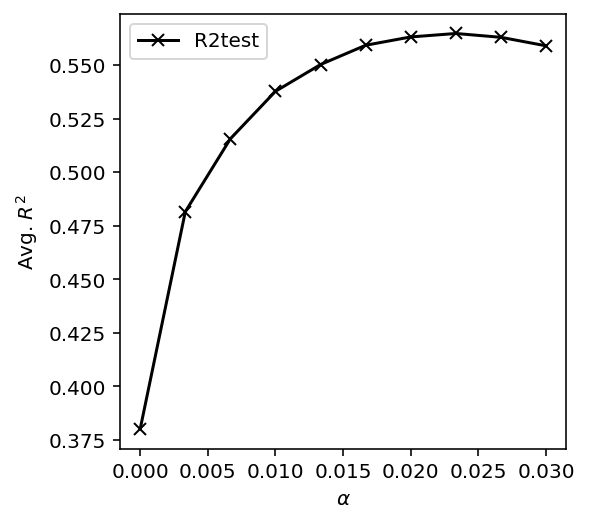

In [44]:
plt.figure(figsize=(4,4))
plt.plot(a_range,mean_R2test,'-xk', label='R2test')
#plt.plot(a_range,mean_MSEtest,'-xr', label='MSE')
plt.xlabel('$\\alpha$')
plt.ylabel('Avg. $R^2$')
plt.legend()
plt.show()

In [45]:
idx_max = np.argmax(mean_R2test)
[mean_R2test[idx_max], a_range[idx_max]]

[0.564855627260515, 0.023333555555555552]

# Results: Lasso

*   Best degree: 2
*   r2 value: .58
*   alpha value: .024




### Degree 1: Elastic Net

In [46]:
a_range = np.linspace(1e-6,0.007,10)
k=10
mean_R2train = []
mean_R2test = []
#mean_MSEtrain = []
#mean_MSEtest = []

tStart = dt.now()
for a in a_range:
  clear_output()
  print('Running a=', a)
  model = ElasticNet(alpha=a,fit_intercept=False)
  print(dt.now()-tStart)
  R2train, R2test = model_testing(x,y,model,k,1,123)
  mean_R2train.append(np.mean(R2train))
  mean_R2test.append(np.mean(R2test))
  #mean_MSEtrain.append(np.mean(MSEtrain))
  #mean_MSEtest.append(np.mean(MSEtest))

Running a= 0.007
0:00:00.307085


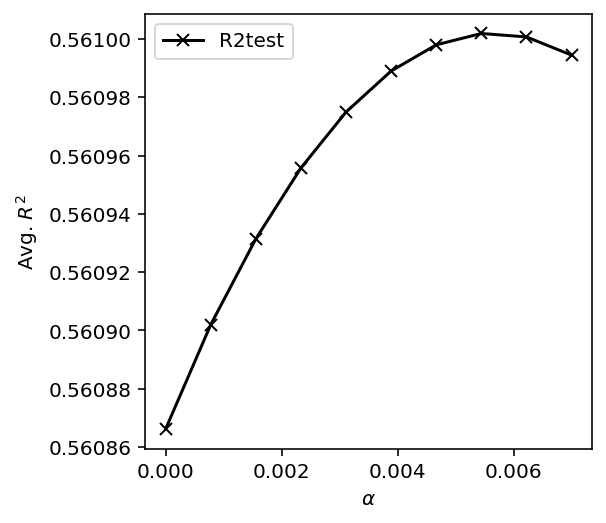

In [47]:
plt.figure(figsize=(4,4))
plt.plot(a_range,mean_R2test,'-xk', label='R2test')
#plt.plot(a_range,mean_MSEtest,'-xr', label='MSE')
plt.xlabel('$\\alpha$')
plt.ylabel('Avg. $R^2$')
plt.legend()
plt.show()

In [48]:
idx_max = np.argmax(mean_R2test)
[mean_R2test[idx_max], a_range[idx_max]]

[0.5610018812047783, 0.005444666666666666]

### Degree 2: Elastic Net

In [55]:
a_range = np.linspace(1e-6,0.016,10)
k=10
mean_R2train = []
mean_R2test = []
#mean_MSEtrain = []
#mean_MSEtest = []

tStart = dt.now()
for a in a_range:
  clear_output()
  print('Running a=', a)
  model = ElasticNet(alpha=a,fit_intercept=False)
  print(dt.now()-tStart)
  R2train, R2test = model_testing(x,y,model,k,2,123)
  mean_R2train.append(np.mean(R2train))
  mean_R2test.append(np.mean(R2test))
  #mean_MSEtrain.append(np.mean(MSEtrain))
  #mean_MSEtest.append(np.mean(MSEtest))

Running a= 0.016
0:00:01.264137


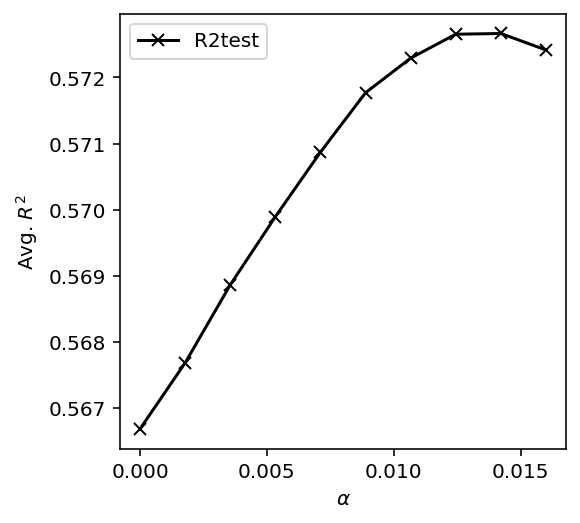

In [56]:
plt.figure(figsize=(4,4))
plt.plot(a_range,mean_R2test,'-xk', label='R2test')
#plt.plot(a_range,mean_MSEtest,'-xr', label='MSE')
plt.xlabel('$\\alpha$')
plt.ylabel('Avg. $R^2$')
plt.legend()
plt.show()

In [57]:
idx_max = np.argmax(mean_R2test)
[mean_R2test[idx_max], a_range[idx_max]]

[0.572663829144889, 0.014222333333333332]

### Degree 3: Elastic Net

In [58]:
a_range = np.linspace(1e-6,0.035,10)
k=10
mean_R2train = []
mean_R2test = []
#mean_MSEtrain = []
#mean_MSEtest = []

tStart = dt.now()
for a in a_range:
  clear_output()
  print('Running a=', a)
  model = ElasticNet(alpha=a,fit_intercept=False)
  print(dt.now()-tStart)
  R2train, R2test = model_testing(x,y,model,k,3,123)
  mean_R2train.append(np.mean(R2train))
  mean_R2test.append(np.mean(R2test))
  #mean_MSEtrain.append(np.mean(MSEtrain))
  #mean_MSEtest.append(np.mean(MSEtest))

Running a= 0.035
0:00:03.567781


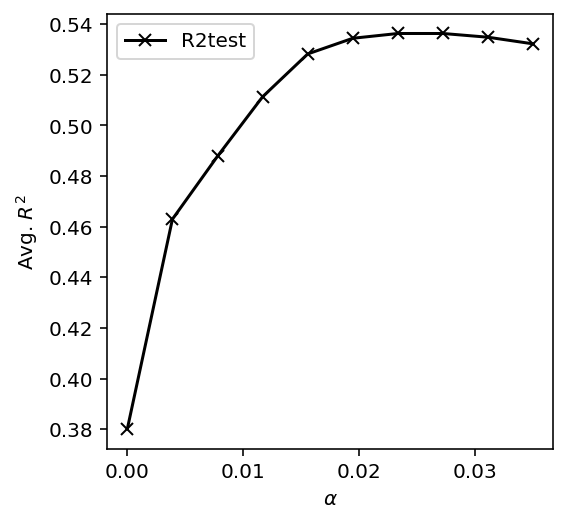

In [59]:
plt.figure(figsize=(4,4))
plt.plot(a_range,mean_R2test,'-xk', label='R2test')
#plt.plot(a_range,mean_MSEtest,'-xr', label='MSE')
plt.xlabel('$\\alpha$')
plt.ylabel('Avg. $R^2$')
plt.legend()
plt.show()

In [60]:
idx_max = np.argmax(mean_R2test)
[mean_R2test[idx_max], a_range[idx_max]]

[0.5363265946372185, 0.02333366666666667]

# Results: ElasticNet 

*   Best Degree: 2
*   r2: .573
*   alpha: .014





# All Results

Ridge:
*   Best degree: 2
*  r2 value: .57
*   alpha value: .40

Lasso:
*   Best degree: 2
*   r2 value: .58
*   alpha value: .024


Elastic Net:
*   Best Degree: 2
*   r2: .57
*   alpha: .014

# Lasso degree 2 is the best model. Alpha: 0.024

After you obtained the best choice of polynomial degree and hyperparameter alpha compute the residuals of the best model on the whole data and determine whether they follow a normal distribution.

In [377]:
model = Lasso(alpha=0.02,fit_intercept=False) #using our best model and best alpha 
model.fit(x,y) #fitting this model on our data 
model.predict(x) #predicts what y values are going to be 
residuals = y - model.predict(x) #getting residuals by subtracting predicted y values from real y values 

[Text(0, 0.5, 'Frequency'), Text(0.5, 0, 'Residuals')]

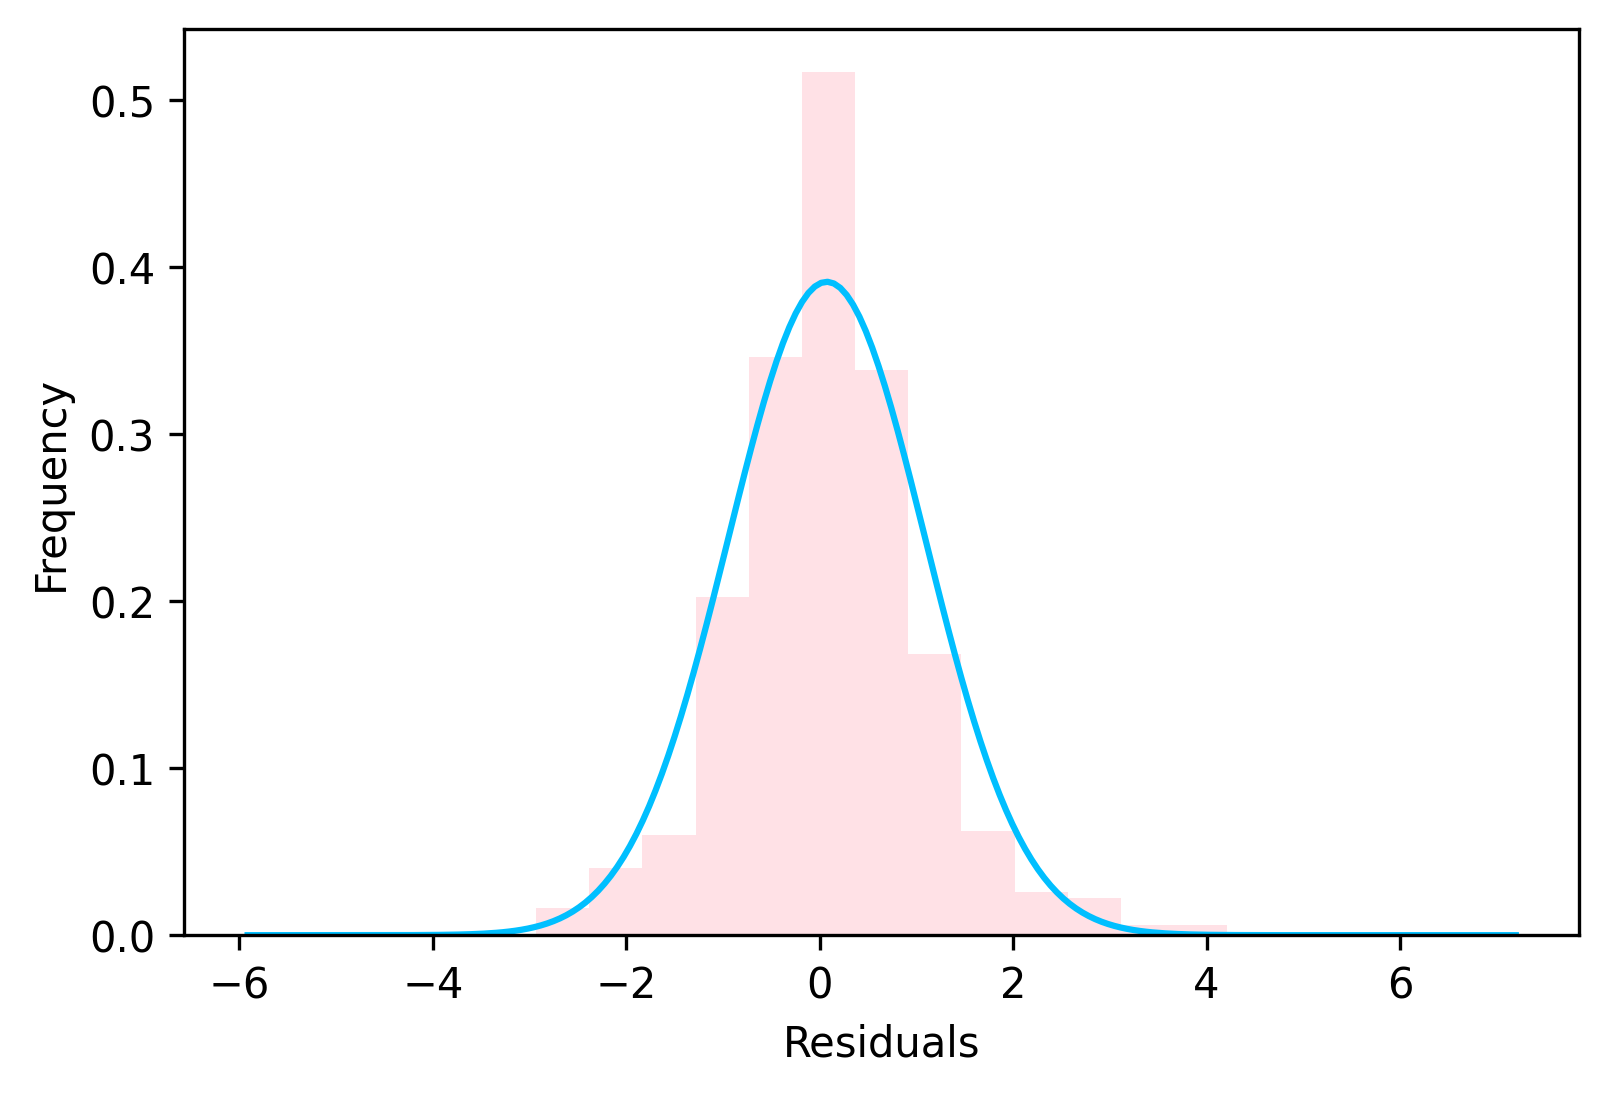

In [378]:
#making distributional plot with our residuals
ax1 = sns.distplot(residuals,
                                        
                  bins=21,
                  kde=False,
                  color='deepskyblue',
                  hist_kws={"color":'lightpink'},
                  fit=stats.norm,
                  fit_kws={"color":'deepskyblue'})
ax1.set(xlabel='Residuals', ylabel='Frequency')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """


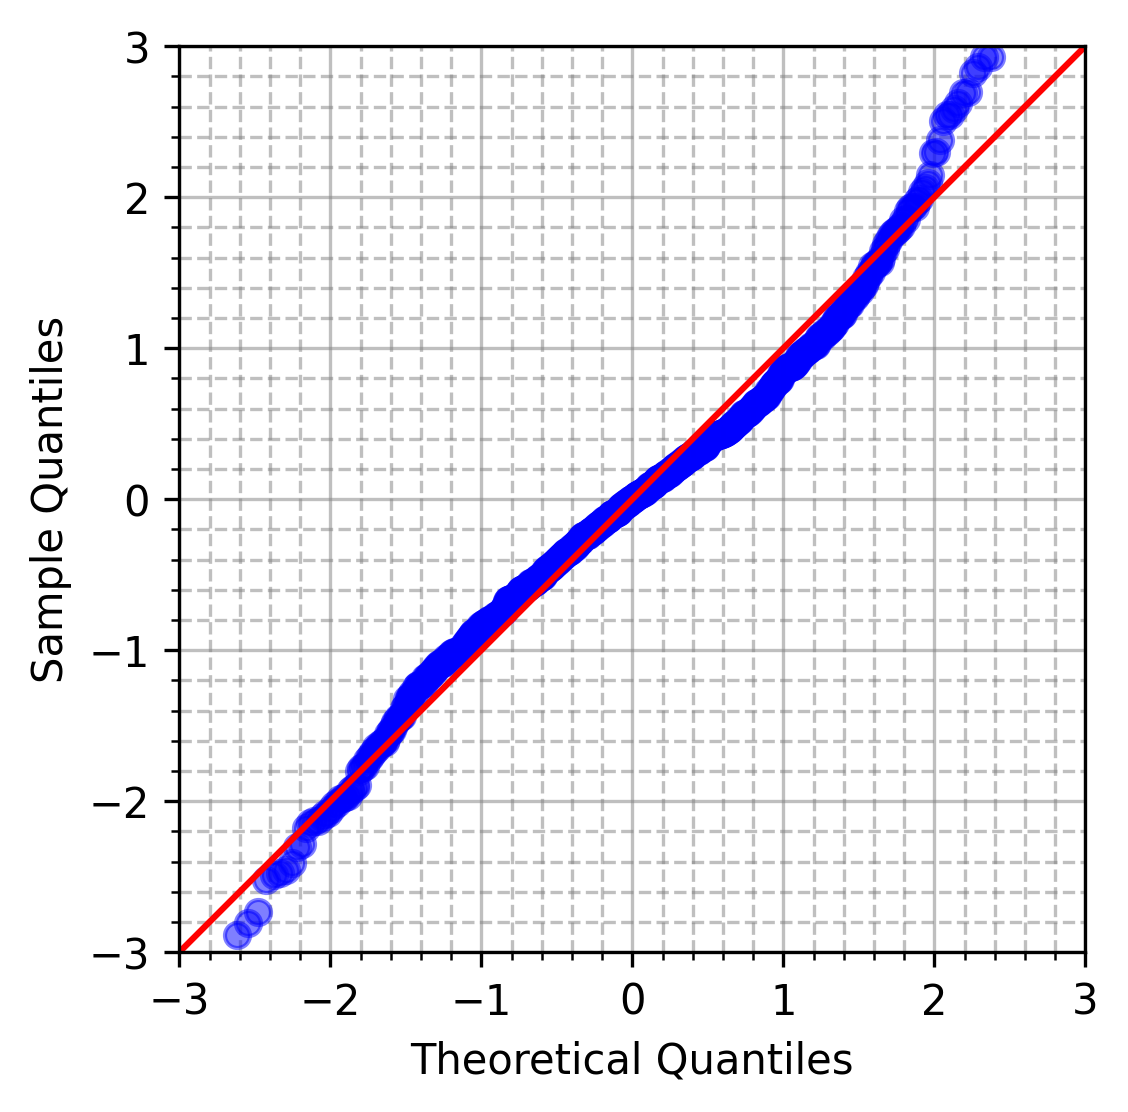

In [379]:
#QQ plot with our residuals 
sm.qqplot((residuals-np.mean(residuals))/np.std(residuals),line='s',alpha=0.5)
plt.xlim([-3,3])
plt.ylim([-3,3])
plt.axes().set_aspect('equal')
plt.grid(b=True,which='major', color ='grey', linestyle='-', alpha=0.5)
plt.grid(b=True,which='minor', color ='grey', linestyle='--', alpha=0.5)
plt.minorticks_on()
plt.show()

In [380]:
array_residuals = np.array(residuals)

In [381]:
#standardize our data for our Kolmogorov-Smirnov and Anderson-Darling tests
ss = StandardScaler()
sresiduals = ss.fit_transform(array_residuals.reshape(-1,1))

In [382]:
#Kolmogorov-Smirnov Test 
stats.kstest(sresiduals.T[0],'norm')
#if p-value above 5%, then it is a normal distribution
#however, p-value is not above 5%, thus we do not have a normal distribution

KstestResult(statistic=0.06273710261971477, pvalue=0.0015020707246278203)

In [383]:
#Anderson-Darling Test 
stats.anderson(sresiduals.T[0],'norm')
#all of the critical values have to be above test statistic to be considered a normal distribution,
#however, the critical values are not above the test statistic thus, the data does not fit a normal distribution

AndersonResult(statistic=6.398762303580384, critical_values=array([0.573, 0.653, 0.784, 0.914, 1.087]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))

From our tests, our data does not fit a normal distribution